# Machine Learning Engineer Nanodegree
## Capstone Project

**Virtual Machine (VM) preparation time prediction**

Sergey Sergeev  
December 31st, 2050

## I. Definition

### Project Overview

I work for the software development company, and we pay high attention to the test automation.
During 15 years of our product development and many implemented customer projects we accumulated a lot of autotests.
Autotests check various parts of our product in different environments, e.g. 

- 1, 2, 4, 8 VM clusters
- RedHat Enterprise Linux (RHEL) version 6 or 7
- different versions of Java (our primary programming language)
- etc...

Individual test's execution times vary from few minutes to several hours depending on complexity and size.

We built the private cloud (based on Openstack) for the continuous autotest execution and a simple Web interface to manage it.
On the dedicated page test engineer or developer may choose the list of tests he want to execute, number of virtual machines, versions of the 3rdparty software to be provisioned in the VMs, and so on.
After that the execution request is queued to be executed as soon as possible according to cloud capacity and current VM consumption.
As a result, engineer receives an email with the test report.
Test reports are also stored in some shared directory for reference, comparison and further analysis needs.     

### Problem Statement

For the higher cloud capacity utilization and better user experience we would like to have a model capable to predict overall test execution time.
This time is a sum of three:

- **Queue time (t1)**: time spent by an execution request in the queue waiting for the free cloud capacity
- **VM preparation time (t2)**: time to create a cluster of VMs and provision it with the requested 3rdparty software
- **Actual test execution time (t3)**: actual test execution till the final report   

In this project, I would focus on t2 estimation only, leaving t1 and t3 for a future.


Here is the brief workflow to prepare the solution:

- Clean up data: remove records about failed cluster creations
- Prepare benchmark model for final solution evaluation
- Remove useless features - e.g. success/failure indicator, number of attempts performed
- Transform original features
- Try various regression models provided by scikit-learn
- Tune the best model with grid search cross-validation
- Test final model on a testing set, compare with the benchmark model. 


### Metrics

[R^2 regression score](https://en.wikipedia.org/wiki/Coefficient_of_determination) (coefficient of determination) would be used as the main evaluation metric.

Additionally, [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error) and [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (root mean squared error) would be used for illustrative purposes.

## II. Analysis

### Data Exploration

In [1]:
# Shared imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import visuals as vs

%matplotlib inline
np.random.seed = 42

Let's load historical data from csv file and explore it.

In [2]:
dtype_corrections = {'with_postgresql_version': str}
data = pd.read_csv('clusters.csv', dtype = dtype_corrections)
print("The original dataset has {} data points with {} variables each.".format(*data.shape))


The original dataset has 1095 data points with 32 variables each.


In [3]:
data.dtypes

cluster_name               object
attempts                    int64
start_ts                    int64
end_ts                      int64
failed                       bool
completed                    bool
vm_count                    int64
build_name                 object
with_conda                   bool
with_conda_version         object
with_docker                  bool
with_docker_version        object
with_flavor                object
with_foundation              bool
with_foundation_version    object
with_gemfire                 bool
with_gemfire_version       object
with_image                 object
with_java_version          object
with_kubernetes              bool
with_kubernetes_version    object
with_memcached               bool
with_memcached_version     object
with_oracle                  bool
with_oracle_version        object
with_os_version            object
with_postgresql              bool
with_postgresql_version    object
with_tibco                   bool
with_tibco_ver

**Brief description of CSV columns:**
- `cluster_name`: The name to refer a particular cluster, primary key of the dataset
- `attempts`: Number of attempts performed to create and provision requested cluster, can be from `1` to `10`. The procedure gives up if a cluster is still failed after 10 subsequent attempts to build it
- `start_ts`: Start timestamp (in milliseconds from 1970, Jan, 1, 00:00:00 UTC)
- `end_ts`: End timestamp (in milliseconds from 1970, Jan, 1, 00:00:00 UTC)
- `failed`: Was it finished successfully or not?
- `completed`: Was it completed (even with failure) or interrupted?
- `vm_count`: Number of requested virtual machines in the cluster, can be from `1` to `26`
- `build_name`: Some unique version identifier in our build system

Other columns (started with `with_` prefix) describe how each of the cluster VM should be provisioned:
- `with_flavor`: Size of VM (in terms of # of CPU, RAM and HDD size)
- `with_os_version`: Operating system version to be used, can be `RHEL6.9`, `RHEL7.3`, `RHEL7.4`
- `with_image`: Custom base VM image to be used, or `_default_` if some prepared RHEL image is sufficient
- `with_java_version`: Java version. For example, `1.8.0_74`, `1.8.0_102`

The other `with_` columns come in pairs:
- `with_<X>` (indicator column): Should `X` software be installed and configured or not?
- `with_<X>_version` (version column): If `X` should be installed, of which version?


For example, [`with_docker = 'True'` and `with_docker_version='18.03.1.ce'`] means Docker 18.03.1.ce should be installed. 

Note, that the dataset also contains records such as [`with_docker = 'False'` and `with_docker_version='18.03.1.ce'`] - this means, that no Docker is needed (version column is ignored in this case).



In [4]:
optional_software = [
    'conda', 'docker', 'foundation', 
    'gemfire', 'kubernetes', 'memcached', 
    'oracle', 'postgresql', 'tibco', 'ulticom'
]

In [5]:
data.head(10)

,cluster_name,attempts,start_ts,end_ts,failed,completed,vm_count,build_name,with_conda,with_conda_version,...,with_memcached_version,with_oracle,with_oracle_version,with_os_version,with_postgresql,with_postgresql_version,with_tibco,with_tibco_version,with_ulticom,with_ulticom_version
0,kalexey.20181227174135,1,1545922452338,1545923103007,False,True,13,20181227_174049_Proj_2127259257,False,4.5.11,...,_default_,False,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
1,sdmitry.20181128184423,1,1543421316335,1543421667461,False,True,1,20181128_183651_Proj_1735463230,False,4.5.11,...,_default_,True,11.2.0,rhel7.4,False,9.5,False,8.4.5,False,_default_
2,igarus.20181221190350,2,1545408262310,1545409537436,False,True,14,20181220_115814_Proj_2696985,False,4.5.11,...,_default_,False,11.2.0,rhel7.4,False,9.5,False,8.4.5,True,9s65
3,sdmitry.20181211190002,1,1544544132560,1544544935177,False,True,9,20181211_161447_Proj_2631643,False,4.5.11,...,_default_,True,11.2.0,rhel7.4,False,9.5,False,8.4.5,False,_default_
4,abondar.20181207141530,1,1544181372440,1544181831985,False,True,4,20181207_083303_Proj_1027219150,False,4.5.11,...,_default_,True,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
5,kalexey.20181227072109,1,1545884532385,1545885127105,False,True,13,20181226_174418_Proj_2127259257,False,4.5.11,...,_default_,False,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
6,maximo.20181130172742,1,1543588116338,1543588336672,True,True,4,20181130_133648_Proj_2409,False,4.5.11,...,_default_,False,11.2.0,rhel6.9,False,9.5,False,8.4.5,False,_default_
7,edrojdina.20181206155824,1,1544102532566,1544102893012,False,True,3,20181206_143754_Proj_1027219150,False,4.5.11,...,_default_,True,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
8,nazarov.20181212152410,1,1544617573021,1544617977311,False,True,1,20181210_133821_Proj_73134446,False,4.5.11,...,_default_,True,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
9,glungu.20181212000220.16171,2,1544570912999,1544571929867,False,True,15,20181212_000220_Proj_189425416,False,4.5.11,...,_default_,False,11.2.0,rhel7.4,False,9.5,False,8.4.5,False,_default_


Let's introduce the **target variable**: time (in seconds) to create a cluster as a difference between end timestamp and start timestamp

In [6]:
data['create_time'] = (data['end_ts'] - data['start_ts']) / 1000 ## measured in seconds

Let's explore statistics over **numerical** columns

In [7]:
data.describe()

,attempts,start_ts,end_ts,vm_count,create_time
count,1095.000000,1.095000e+03,1.095000e+03,1095.000000,1095.000000
mean,1.296804,1.546146e+12,1.546147e+12,5.042009,593.556932
std,1.198162,1.907391e+09,1.907442e+09,5.017708,372.183086
min,1.000000,1.543070e+12,1.543071e+12,1.000000,50.761000
25%,1.000000,1.544439e+12,1.544439e+12,1.000000,353.266000
50%,1.000000,1.545925e+12,1.545926e+12,3.000000,499.470000
75%,1.000000,1.548057e+12,1.548057e+12,9.000000,729.423000
max,10.000000,1.549356e+12,1.549356e+12,26.000000,4539.504000


Numerical feature statistics conclusions:
- Most of the requests were completed in 1-2 attempts
- VM count averages are relatively low (median = 3 and mean = 5) but the tail is heavy
- There are outliers in the dataset (look at the max `attempts` and max `create_time`)


Now, let's look at the **boolean and categorical** columns.


In [8]:
def get_unique(df, name = ""):
    df = pd.DataFrame(df.apply(lambda x: x.nunique()), columns = ['unique values'])
    df.index.name = name
    return df

display(get_unique(data.select_dtypes(include = 'bool'), "Boolean feature"))

,unique values
Boolean feature,
failed,2
completed,2
with_conda,1
with_docker,2
with_foundation,2
with_gemfire,2
with_kubernetes,2
with_memcached,1
with_oracle,2


As we can see, not all possible software indicators are used in the dataset.

Let's look at the software indicator correlations.

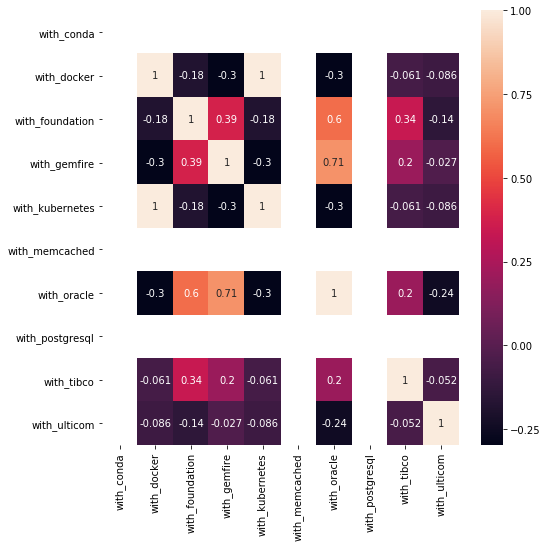

In [9]:
software_indicators = data[['with_{}'.format(x) for x in optional_software]]
corr = software_indicators.corr()

_, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, annot = True, ax = ax);

Conclusions about software indicator features:
- Optional software `conda`, `memcached` and `postgresql` were not requested for clusters we have in the dataset
- `docker` and `kebernetes` were used together all the time as the correlation is equal to 1.0
- there is a good `oracle`correlation with `gemfire` (0.71), and `oracle` with `foundation` (0.6)

In [10]:
cat_data = data.select_dtypes(include = 'object')
software_version_cols = ['with_{}_version'.format(x) for x in optional_software]
software_versions = cat_data[software_version_cols]
other_cat_data = cat_data.drop(columns = software_version_cols)

display(get_unique(other_cat_data, 'Categorical feature'))

,unique values
Categorical feature,
cluster_name,1095
build_name,488
with_flavor,1
with_image,1
with_java_version,5
with_os_version,3


`with_flavor` and `with_image` are always the same, so we can safely remove them from features

In [11]:
display(get_unique(software_versions, 'Optional software'))

,unique values
Optional software,
with_conda_version,1
with_docker_version,1
with_foundation_version,1
with_gemfire_version,5
with_kubernetes_version,1
with_memcached_version,2
with_oracle_version,1
with_postgresql_version,1
with_tibco_version,1


Most of the software versions don't vary, except of `gemfire` and `ulticom`. Two versions of `memcached` looks like an error in the dataset. Anyway, `memcached` is not used as we've seen above, so we can ignore it.

### Exploratory Visualization

In [12]:
plot_labels = {
    "vm_count": "Cluster size",
    "create_time": "Create time",
    "attempts": "Attempts",
}

def countplot0(x_name, data, ax):
    sns.countplot(x=x_name, data=data, ax=ax)
    ax.set_title("Observations vs. " + plot_labels[x_name])
    ax.set_xlabel(plot_labels[x_name] + " (" + x_name +")")
    ax.set_ylabel("Count")

def boxplot0(x_name, y_name, data, ax):
    sns.boxplot(x=x_name, y=y_name, data=data, ax=ax)
    x_label = plot_labels[x_name]
    y_label = plot_labels[y_name]
    ax.set_xlabel("{} ({})".format(x_label, x_name))
    ax.set_ylabel("{} ({})".format(y_label, y_name))
    ax.set_title("{} vs. {}".format(y_label, x_label))
    
def scatterplot0(x_name, y_name, data, ax):
    colors = ['red' if failed else 'green' for failed in data['failed']]
    sizes = data['attempts'] * 40
    
    ax.scatter(x=data[x_name], y=data[y_name], marker='o', sizes=sizes, c=colors, alpha=0.4)

    x_label = plot_labels[x_name]
    y_label = plot_labels[y_name]
    ax.set_xlabel("{} ({})".format(x_label, x_name))
    ax.set_ylabel("{} ({})".format(y_label, y_name))
    ax.set_title("{} vs. {}".format(y_label, x_label))

def plots(x_name, y_name, data):
    _, ax = plt.subplots(1, 3, figsize=(24,6))
    countplot0(x_name, data, ax[0])
    boxplot0(x_name, y_name, data, ax[1])
    scatterplot0(x_name, y_name, data, ax[2])
    

#### Creation time (`create_time`) vs. cluster size (`vm_count`)
From common sense, cluster size (`vm_count`) should be the most important feature to predict the target variable - cluster creation time (`create_time`).


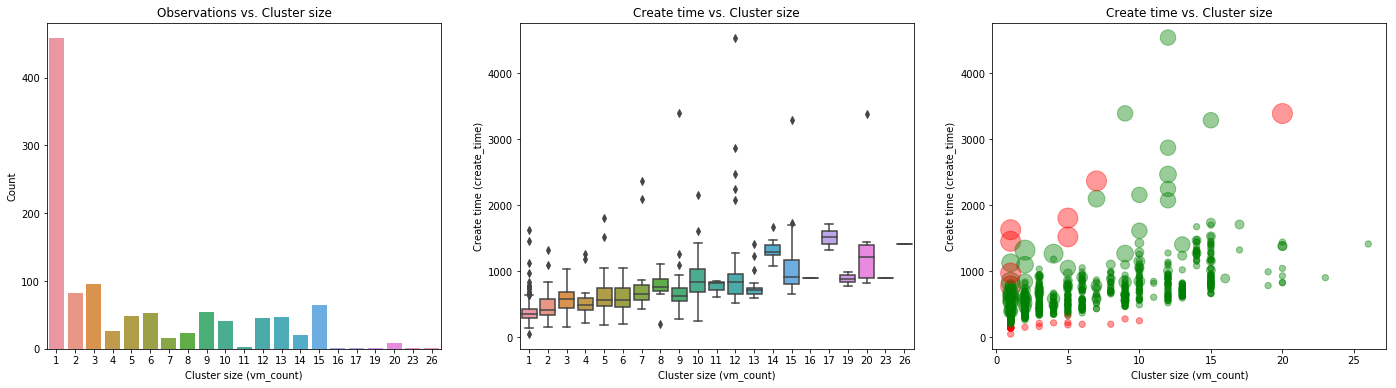

In [13]:
plots("vm_count", "create_time", data)

Notes on the third plot: 
- Сolors are red for `failed = True` and green for `failed = False`
- Marker size corresponds to the number of `attempts`

Things to notice from the plots above:
- About a half of the observations are for `vm_count == 1`
- For `vm_count > 15` we have almost no observations in our dataset (e.g. for `vm_count in [18, 21, 22, 24, 25]` we have no observations at all)
- There are outliers for almost every `vm_count` value
- All data for `vm_count == 14` looks like outliers if we compare it to neighbours (`vm_count` 13 and 15)
- Requests that were either `failed` or completed after a high number of `attempts` are mostly responsible for outliers
- Small red markers at the bottom of the third plot look like dataset errors. Scripts that create and provision VM cluster should mark a request failed after 10 unsuccesful attempts only. So, we have a bug either in the scripts or in scripts logging.

#### Special case (`vm_count == 1`)
Now let's zoom in data for `vm_count == 1` as it's the half of the dataset. 

In contrast to plots above we'll now split it over the number of `attempts`.

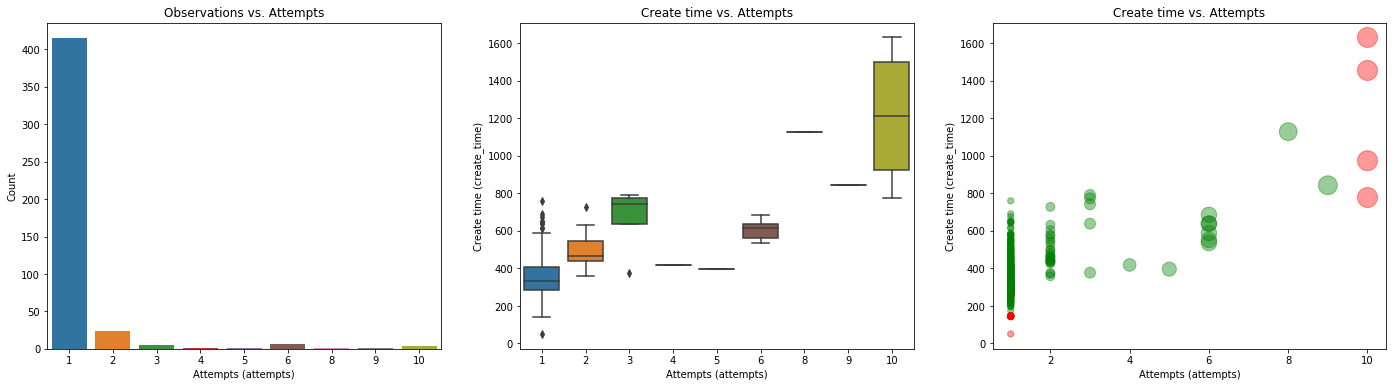

In [14]:
data_vm_count_1 = data[data['vm_count'] == 1]
plots("attempts", "create_time", data_vm_count_1)

Things to notice from the plots above:
- Almost half of the original observations (~430 out of 1000) are single VM requests (`vm_count == 1`) successfully completed in a single attempt (`attempts == 1`)
- There are still outliers even for `attempts == 1` - see the plot in the middle

### Algorithms and Techniques

Few scikit-learn models available out of the box would be compared:
- Linear regression 
- Decision tree
- Ridge
- RANSAC, Huber and Theil-Sen regressions - useful in case of data with many outliers ([article](https://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html#sphx-glr-auto-examples-linear-model-plot-robust-fit-py]))
and a couple of ensemble models
- Random forest
- Gradient boosting


### Benchmark

As a benchmark, I would use a simple model which doesn't take into account anything except requested VM cluster size (no details about 3rdparty software to be provisioned).<br/>The model should calculate expected `create_time` as an average over historical data for clusters of the same size (number of VMs).


## III. Methodology

### Data Preprocessing

The first step is to remove observations that are either `failed` or completed after many `attempts` (a lot of attempts are usually caused by some intermittent issues in the underlying OpenStack cloud that we can't predict).

In [15]:
bad_data = data[(data['failed']) | (data['attempts'] > 5)]

bad_data_count = bad_data.shape[0]
bad_data_percent = bad_data_count * 100 / data.shape[0]
print("Found {} bad data points, {:.2f}% of the whole dataset".format(bad_data_count, bad_data_percent))
display(bad_data[['cluster_name', 'attempts', 'failed', 'vm_count', 'create_time']].head(10))

Found 60 bad data points, 5.48% of the whole dataset


,cluster_name,attempts,failed,vm_count,create_time
6,maximo.20181130172742,1,True,4,220.334
25,sdmitry.20190114185031,6,False,12,2076.067
29,marsels.20181128142358,1,True,5,225.501
35,marsels.20181204093910,10,True,1,1455.075
44,sdmitry.20190114185047,6,False,12,2872.506
70,edrojdina.20181206140532,1,True,1,144.247
71,nikolayk.20181225093155,10,True,1,1631.033
88,abondar.20190204124856,6,False,10,1614.971
135,marsels.20181128202554,10,True,5,1521.896
143,maximo.20190109104914,8,False,1,1129.215


In [16]:
good_data = data.drop(bad_data.index)
good_data_count = good_data.shape[0]
good_data_percent = good_data_count * 100 / data.shape[0]
print("We have {} good data points now, {:.2f}% of the original dataset".format(good_data_count, good_data_percent))

We have 1035 good data points now, 94.52% of the original dataset


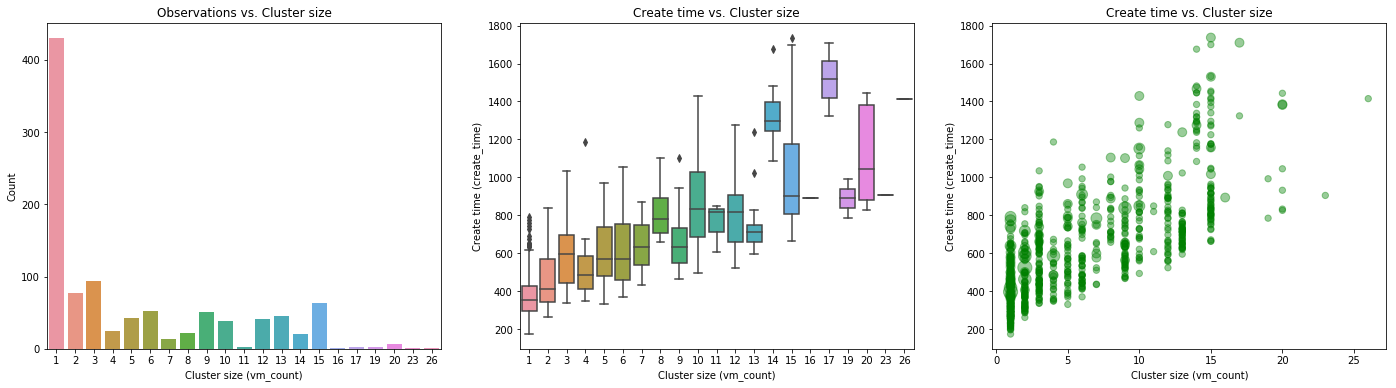

In [17]:
plots("vm_count", "create_time", good_data)

Now let's prepare features and target variable.

Features from original dataset to be **used**:
- `vm_count`
- `with_os_version`: Operation system version (need to be one-hot encoded)
- Optional software indicators (`with_<X>`)

Features from original dataset to be **dropped**:
- `with_flavor` and `with_image`: they are always the same in the dataset according to data analysis
- `cluster_name`: Just a primary key, no useful information
- `build_name`: Some unique version identifier, no useful information
- `with_<X>_version`: optional software versions. Knowing cluster provisioning internals, software installations are almost the same for different sofware version, so I do not expect any significant change of the target variable because of version differenсe 

These features are **dropped** as well as they are actually the **outcome** of cluster provisioning, and not something we know before placing a cluster request:
- `attempts`
- `start_ts`
- `end_ts`
- `failed`
- `completed`


In [18]:
# target variable
y = good_data['create_time']

# prepare feature names
feature_names = ['vm_count', 'with_os_version']
feature_names.extend(['with_{}'.format(s) for s in optional_software])
print(feature_names)

# prepare features
X = good_data[feature_names]
X = pd.get_dummies(X, columns = ['with_os_version'])

display(X.head(10))

['vm_count', 'with_os_version', 'with_conda', 'with_docker', 'with_foundation', 'with_gemfire', 'with_kubernetes', 'with_memcached', 'with_oracle', 'with_postgresql', 'with_tibco', 'with_ulticom']


,vm_count,with_conda,with_docker,with_foundation,with_gemfire,with_kubernetes,with_memcached,with_oracle,with_postgresql,with_tibco,with_ulticom,with_os_version_rhel6.9,with_os_version_rhel7.3,with_os_version_rhel7.4
0,13,False,False,False,False,False,False,False,False,False,False,0,1,0
1,1,False,False,False,True,False,False,True,False,False,False,0,0,1
2,14,False,False,False,True,False,False,False,False,False,True,0,0,1
3,9,False,False,True,True,False,False,True,False,False,False,0,0,1
4,4,False,False,False,True,False,False,True,False,False,False,0,1,0
5,13,False,False,False,False,False,False,False,False,False,False,0,1,0
7,3,False,False,True,True,False,False,True,False,False,False,0,1,0
8,1,False,False,True,False,False,False,True,False,False,False,0,1,0
9,15,False,False,False,False,False,False,False,False,False,False,0,0,1
10,2,False,False,False,False,False,False,False,False,False,False,0,1,0


### Implementation

First, split data into training and test sets, and prepare a function to report metrics.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## report metrics 
def get_scores(name, y_true, y_pred):
    df = pd.DataFrame({
        'Name' : [name],
        'R^2'  : [round(r2_score(y_true, y_pred), 4)],
        'MAE'  : [round(mean_absolute_error(y_true, y_pred), 4)],
        'RMSE' : [round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)],
    })
    return df.set_index('Name')

## train and report metrics of several models
def fit_predict(models, X_train, X_test, y_train, y_test, title=""):
    for name, reg in models.items():
        reg.fit(X_train, y_train)

    print("=== Train metrics " + title + " ===")
    scores = [get_scores(name, y_train, reg.predict(X_train)) for name, reg in models.items()]
    display(pd.concat(scores))
    print("")
    print("=== Test metrics " + title + " ===")
    scores = [get_scores(name, y_test, reg.predict(X_test)) for name, reg in models.items()]
    display(pd.concat(scores))


Next, prepare the benchmark model:

In [20]:
class BenchmarkModel():
    def __init__(self, feat='vm_count', avg='mean'):
        self.feat = feat
        self.avg = avg 

    def fit(self, X, y):
        df = pd.concat([X, pd.Series(y, name='y')], axis=1)
        groupby = df['y'].groupby(df[self.feat])
        if self.avg == 'mean':
            avg = pd.DataFrame(groupby.mean())
        elif self.avg == 'median':
            avg = pd.DataFrame(groupby.median())
        
        ## we may not have target data for some values of feat, so let's interpolate them
        max_vm_count = 26
        avg = avg.reindex(pd.Index(range(1, max_vm_count + 1), name=self.feat))
        avg = avg.interpolate()
        
        self.avg = avg
        return self
    
    def predict(self, X):
        df = pd.merge(X, self.avg, on=self.feat, how='left')
        return df['y']


And obtain benchmark metrics:

In [21]:
benchmark_models = {
    "Benchmark (mean)"   : BenchmarkModel(avg="mean"), 
    "Benchmark (median)" : BenchmarkModel(avg="median"),
}
       
fit_predict(benchmark_models, X_train, X_test, y_train, y_test)


=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
Benchmark (mean),0.6912,114.8219,150.8061
Benchmark (median),0.6691,111.2042,156.1141



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
Benchmark (mean),0.7182,116.4822,152.1524
Benchmark (median),0.6810,118.1614,161.8828


**R-squared score of 0.7182 is taken as the benchmark**.

Let's check several models available in scikit-learn with their parameters set to the respective defaults:

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, RANSACRegressor, HuberRegressor, TheilSenRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    "Decision Tree" : DecisionTreeRegressor(),
    "Linear" : LinearRegression(),
    "Ridge" : RidgeCV(),
    "RANSAC" : RANSACRegressor(), 
    "Huber" : HuberRegressor(),
    "Theil-Sen" : TheilSenRegressor(),
    "Random Forest" : RandomForestRegressor(n_estimators=20), 
    "Gradient Boosting" : GradientBoostingRegressor(),
}

       
fit_predict(models, X_train, X_test, y_train, y_test)

=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
Decision Tree,0.8778,69.4980,94.8857
Linear,0.8229,86.2114,114.2190
Ridge,0.8229,86.2084,114.2193
RANSAC,0.8083,85.9055,118.8305
Huber,0.8177,84.0403,115.8710
Theil-Sen,0.7882,89.1417,124.9042
Random Forest,0.8742,71.8131,96.2660
Gradient Boosting,0.8621,75.8767,100.7975



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
Decision Tree,0.8348,87.6430,116.4958
Linear,0.8395,85.1727,114.8359
Ridge,0.8394,85.1669,114.8499
RANSAC,0.8195,88.0568,121.7613
Huber,0.8293,85.6247,118.3986
Theil-Sen,0.7944,89.7515,129.9469
Random Forest,0.8416,86.6400,114.0825
Gradient Boosting,0.8480,83.7809,111.7398


All the selected models obtained R-squared score higher than benchmark on the test dataset. Among them **Gradient Boosting** has the highest one. Mean absolute error (MAE) and RMSE (root mean squared error) are also least for Gradient Boosting.

### Refinement

In this section, we would try two approaches to improve Gradient Boosting:
- Grid search (over regressor tunable parameters)
- Transforming target: according to the [scikit-learn article](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py), this approach can improve regressors' scores in some cases. 

In [23]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
param_grid = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200, 300],
    "learning_rate": [.05, .1, .2, .3],
    "subsample": [.8, .9, 1.0]
    }
cv = ShuffleSplit(n_splits=10, test_size=.1)
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid, 
                           cv=cv, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 854 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 1554 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.6min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=0.9, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
fit_predict({"Optimized Gradient Boosting": grid_search.best_estimator_}, X_train, X_test, y_train, y_test)


=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
Optimized Gradient Boosting,0.8609,75.5352,101.2055



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
Optimized Gradient Boosting,0.847,83.5031,112.1052


Gradient Boosting optimized with grid search obtained R-squared score (**0.8515**) just slightly different than Gradient Boosting trained with default parameter values (**0.8480**). Looks like GB default parameters are already good enough for our dataset.

Now, let's try to transform or target variable with log() function before training Gradient Boosting regressor:

In [25]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
reg = TransformedTargetRegressor(
    regressor=GradientBoostingRegressor(),
    func=np.log, inverse_func=np.exp
)

fit_predict({"TransformedTargetRegressor": reg}, X_train, X_test, y_train, y_test)


=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
TransformedTargetRegressor,0.8599,74.7382,101.5772



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
TransformedTargetRegressor,0.8485,82.0538,111.5576


Now the model obtained slightly higher R-squared score: **0.8485** (as well as lower MAE and RMSE), but it's not extremely different. 

If we recall that MAE is measured in seconds, the difference between two models is just ~1.7 seconds - it's not that important from end user point of view.

So, after the attempts to refine the model above, let's stick to the basic **Gradient Boosting** with default parameter values.

## IV. Results

### Model Evaluation and Validation

Let's evaluate dataset feature importances:


In [26]:
reg = GradientBoostingRegressor().fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_test.columns, 'importance': reg.feature_importances_})
importance.sort_values(by='importance', ascending=False, inplace=True)
importance = importance.set_index('feature')
importance.head(10)

,importance
feature,
vm_count,0.743705
with_ulticom,0.093252
with_kubernetes,0.059044
with_docker,0.050621
with_gemfire,0.016160
with_foundation,0.013903
with_tibco,0.010548
with_os_version_rhel7.4,0.006011
with_oracle,0.003340


As expected, `vm_count` is by far the most important feature to predict target variable. 

Let's limit train and test datasets to contain less variation in `vm_count` feature and check Gradient Boosting scores on these limited datasets:
- `vm_count <= 1`
- `vm_count <= 2`
- ... and so on

In [27]:
scores = []
for i in range(1, 16):
    X_train_i = X_train[X_train['vm_count'] <= i]
    X_test_i = X_test[X_test['vm_count'] <= i]
    y_train_i = y_train.loc[X_train_i.index]
    y_test_i = y_test.loc[X_test_i.index]
    
    y_pred = GradientBoostingRegressor().fit(X_train_i, y_train_i).predict(X_test_i)
    scores.append(get_scores("Gradient Boosting: vm_count <= {}".format(i), y_test_i, y_pred))

scores.append(
    get_scores("Gradient Boosting: full dataset", y_test, 
               GradientBoostingRegressor().fit(X_train, y_train).predict(X_test)))
pd.concat(scores)


,R^2,MAE,RMSE
Name,,,
Gradient Boosting: vm_count <= 1,0.1922,73.2785,102.3410
Gradient Boosting: vm_count <= 2,0.2660,72.6217,99.4291
Gradient Boosting: vm_count <= 3,0.4936,81.3403,110.6632
Gradient Boosting: vm_count <= 4,0.4897,80.8451,109.6870
Gradient Boosting: vm_count <= 5,0.5227,79.3627,107.5129
Gradient Boosting: vm_count <= 6,0.5421,80.1081,108.0107
Gradient Boosting: vm_count <= 7,0.5535,79.2759,106.6586
Gradient Boosting: vm_count <= 8,0.6215,80.1723,107.6306
Gradient Boosting: vm_count <= 9,0.6443,81.5890,108.5456


As expected, less variation in `vm_count` in train dataset gives us less accurate model with limited ability to capture target variable variance. R-squared score increases with `vm_count` variation.

However, if we look at MAE, it's value doesn't change a lot (in interval from 72 to 83 seconds). This means we can rely on model predictions about expected cluster creation time.

### Justification

Let's compare final model with the benchmark:

In [28]:
models = {
    "Benchmark (mean)"  : BenchmarkModel(avg="mean"), 
    "Gradient Boosting" : GradientBoostingRegressor(),
}
       
fit_predict(models, X_train, X_test, y_train, y_test)

=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
Benchmark (mean),0.6912,114.8219,150.8061
Gradient Boosting,0.8621,75.8767,100.7975



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
Benchmark (mean),0.7182,116.4822,152.1524
Gradient Boosting,0.8481,83.7501,111.6990


According to the results above, **Gradient Boosting** model better explains data variance and produces better predictions than simple benchmark model which take into account just cluster size.

So, this model can be taken as a first solution for the explored problem. 

Approaches to build better models discussed below.

## V. Conclusion

### Free-Form Visualization

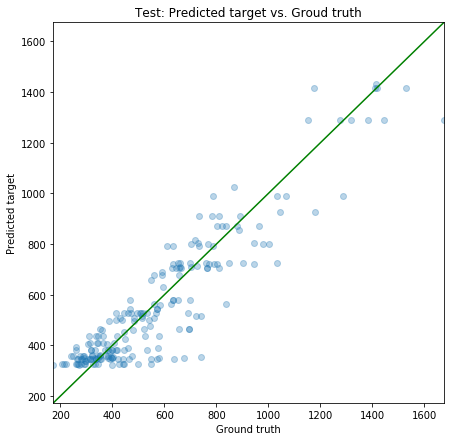

In [56]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(7,7))
    plt.title("Test: Predicted target vs. Groud truth")
    plt.xlabel("Ground truth")
    plt.ylabel("Predicted target")
    plt.scatter(x=y_true, y=y_pred, marker='o', alpha=.3)

    min_lim = min(y_true.min(), y_pred.min())
    max_lim = max(y_true.max(), y_pred.max())
    plt.plot([min_lim, max_lim], [min_lim, max_lim], color = 'green')
    plt.xlim(min_lim, max_lim)
    plt.ylim(min_lim, max_lim)
    plt.show()

reg = GradientBoostingRegressor().fit(X_train, y_train)
y_pred = reg.predict(X_test)
plot_predictions(y_test, y_pred)

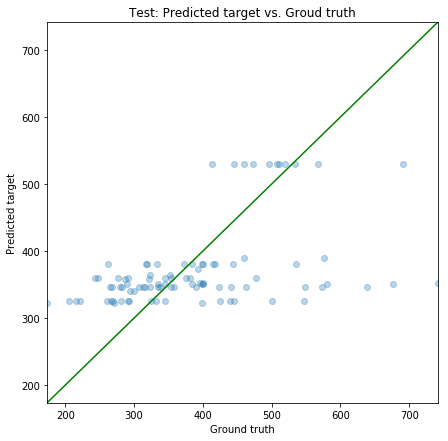

In [57]:
X_test_1 = X_test[X_test['vm_count'] == 1]
y_test_1 = y_test.loc[X_test_1.index]
y_pred_1 = reg.predict(X_test_1)

plot_predictions(y_test_1, y_pred_1)

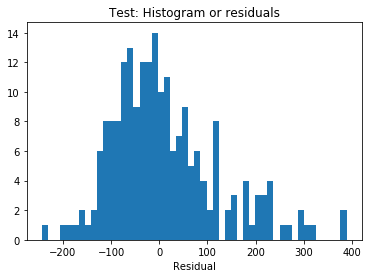

In [53]:
# plt.figure(figsize=(10,10))
plt.title("Test: Histogram or residuals")
plt.xlabel("Residual")
plt.hist(y_test - y_pred, bins=50)
plt.show()

In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection

In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement

In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?